<a href="https://colab.research.google.com/github/Viliuskerutis/AML/blob/main/Lukas_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Viral Data Analysis

Date: 2020.10.06

Author: © 2020 Lukas Stankevičius 

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from https://ourworldindata.org/ to answer the following questions:

1. [When were the most news articles published about coronavirus in 15min.lt?](#Q1)
1. [Why April was so intense in covid related news articles in 15min.lt?](#Q2)
1. [Can we predict number of COVID articles from covid data better than with only articles history?](#Q3)

We additionally use data from:
* [Lithuanian news website 15min.lt](https://www.15min.lt)

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# library for very nice progress bars:
from tqdm.auto import trange, tqdm
from time import time
start_t = time()
import seaborn as sns
# !pip install scrapy
import scrapy, json
from scrapy.crawler import CrawlerProcess

In [ ]:
# note that this will not work in windows. downlad manually and place into your folder where this notebook is located
file_adress = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
!wget -c {file_adress}

--2020-10-06 12:49:40--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 84.201.158.88, 84.201.178.107, 2a03:b0c0:3:e0::32e:b001, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|84.201.158.88|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 10657172 (10M), 42559 (42K) remaining [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[+++++++++++++++++++>]  10,16M   144KB/s    in 0,3s    

2020-10-06 12:49:41 (144 KB/s) - ‘owid-covid-data.csv’ saved [10657172/10657172]



In [ ]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

In [ ]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

Select only that is interesting to us

In [ ]:
columns_to_select = ["total_cases","new_cases","new_cases_smoothed","total_deaths","new_deaths",
                     "new_deaths_smoothed","total_cases_per_million","new_cases_per_million",
                     "new_cases_smoothed_per_million","total_deaths_per_million","new_deaths_per_million",
                     "new_deaths_smoothed_per_million","new_tests","total_tests","total_tests_per_thousand",
                     "new_tests_per_thousand","new_tests_smoothed","new_tests_smoothed_per_thousand",
                     "tests_per_case","positive_rate", "date"]
# , "total_cases"
rows_boolean_to_select = df['location']=="Lithuania"

df = df.loc[rows_boolean_to_select, columns_to_select].fillna(0)
df.head()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,date
25650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-12-31
25651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01
25652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-02
25653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-03
25654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-04


### Let's scrape additional data - article titles during 2020 year in 15min.lt website
Process usually starts by going to https://www.15min.lt/robots.txt and looking for sitemaps... Then using a lot of debugging with `set_trace` to come up with correct `xpath`...

In [ ]:
# from IPython.core.debugger import set_trace


class MyPipeline(object):

    def open_spider(self, spider):
        self.file = open('additional_data.jl', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item), ensure_ascii=False) + "\n"
        self.file.write(line)
        return item


class MySpider(scrapy.Spider):
    
    name = "15min"
    the_most_popular_user_agent = \
    pd.read_csv("https://github.com/yusuzech/top-50-user-agents/raw/master/user_agent.csv").loc[0, "User agent"]
    start_urls = ['https://www.15min.lt/static/sitemaps/main/articles/2020/sitemap_1.xml',
                  'https://www.15min.lt/static/sitemaps/main/articles/2020/sitemap_2.xml']
    custom_settings = {
        'USER_AGENT': the_most_popular_user_agent,
        'ITEM_PIPELINES': {'__main__.MyPipeline': 300},
        'HTTPCACHE_ENABLED': True,
        'DOWNLOAD_DELAY': 0.1,
        'DOWNLOAD_FAIL_ON_DATALOSS':False,
        'LOG_LEVEL': 'INFO',
    }


    def parse(self, response):
        response.selector.remove_namespaces()
        urls = response.xpath("//link/@href").extract()
        dates = response.xpath("//publication_date/text()").extract()
        for url, date in zip(urls, dates):
            yield {'title':url.split('/')[-1].rsplit('-', maxsplit=2)[0], 'date':date}

            
if __name__ == "__main__":
    process = CrawlerProcess()
    process.crawl(MySpider)
    process.start()

2020-10-06 12:49:43 [scrapy.utils.log] INFO: Scrapy 2.3.0 started (bot: scrapybot)
2020-10-06 12:49:43 [scrapy.utils.log] INFO: Versions: lxml 4.5.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 20.3.0, Python 3.7.9 (default, Aug 31 2020, 12:42:55) - [GCC 7.3.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.1.1, Platform Linux-5.4.0-48-generic-x86_64-with-debian-buster-sid
2020-10-06 12:49:43 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-10-06 12:49:43 [scrapy.crawler] INFO: Overridden settings:
{'DOWNLOAD_DELAY': 0.1,
 'DOWNLOAD_FAIL_ON_DATALOSS': False,
 'HTTPCACHE_ENABLED': True,
 'LOG_LEVEL': 'INFO',
 'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36'}
2020-10-06 12:49:43 [scrapy.extensions.telnet] INFO: Telnet Password: 8b10a7e9ce311355
2020-10-06 12:49:43 [scrapy.middleware] INFO: Enabled extensio

In [ ]:
items = []
with open("additional_data.jl") as f:
    for l in tqdm(f):
        item = json.loads(l)
        items.append((item['date'], item['title']))
df_add = pd.DataFrame.from_records(items, columns=["date", "title"])
df_add.head()

,date,title
0,2020-01-01T00:00:00+02:00,prezidentas-gitanas-nauseda-sveikina-su-naujai...
1,2020-01-01T00:25:07+02:00,garsiai-domantas-sabonis-metus-baige-ispudinga...
2,2020-01-01T00:32:29+02:00,lrt-metu-apdovanojimu-laimetojai-populiariausi...
3,2020-01-01T01:17:41+02:00,darius-labanauskas-apie-naujuosius-kelyje-cemp...
4,2020-01-01T08:24:15+02:00,15-pasaulio-vietu-i-kurias-dar-galejote-patekt...


In [ ]:
key_words = ['covid', 'koron']
df_add["about covid"] = df_add['title'].str.contains('|'.join(key_words), regex=True)
df_add = df_add.loc[df_add['about covid'], :]
df_add.head()

,date,title,about covid
1587,2020-01-09T07:27:12+02:00,naujas-koronavirusas-sukele-virusines-pneumoni...,True
2590,2020-01-13T15:22:09+02:00,pso-tailande-uzregistruotas-pirmas-kinijoje-si...,True
4158,2020-01-20T17:34:37+02:00,kinija-naujuoju-koronavirusu-zmones-gali-uzsik...,True
4236,2020-01-21T07:59:38+02:00,kinija-pranese-apie-ketvirtanaujojo-koronaviru...,True
4926,2020-01-23T15:07:53+02:00,viskas-ka-turite-zinoti-apie-naujo-koronavirus...,True


In [ ]:
df_add['date'] = pd.to_datetime(df_add['date'], utc=True)
my_data = df_add.resample('D', on='date')[['title']].count().rename(columns={'title': '#articles'})
my_data.head()

,#articles
date,
2020-01-09 00:00:00+00:00,1
2020-01-10 00:00:00+00:00,0
2020-01-11 00:00:00+00:00,0
2020-01-12 00:00:00+00:00,0
2020-01-13 00:00:00+00:00,1


<AxesSubplot:xlabel='date'>

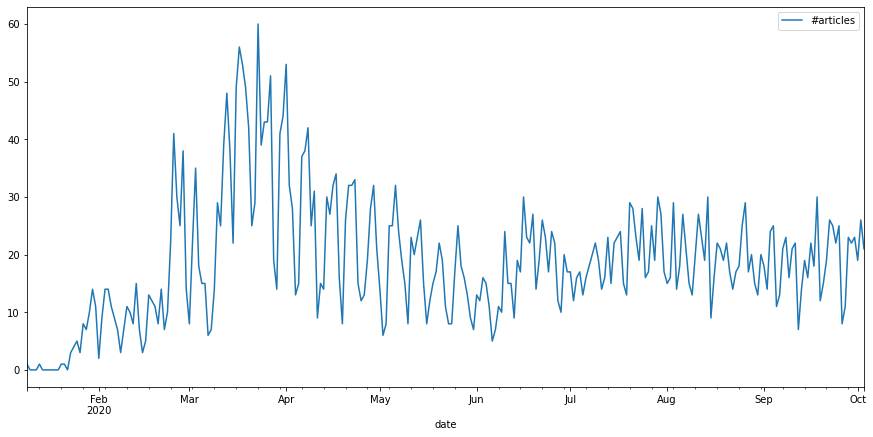

In [ ]:
my_data.plot(figsize=(15,7))

In [ ]:
data_prepared_time = time()
print(f"elapsed time is {data_prepared_time-start_t:.2f} seconds")

elapsed time is 33.19 seconds


In [ ]:
df['date'] = pd.to_datetime(df['date'], utc = True)
df_all = df.merge(my_data, on='date')
df_all.head()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,date,#articles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-09 00:00:00+00:00,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-10 00:00:00+00:00,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-11 00:00:00+00:00,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12 00:00:00+00:00,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-13 00:00:00+00:00,1


<a id='Q1'></a>
## 1. When were the most news articles published about coronavirus in 15min.lt?


We have already seen a plot showing it around april. Let's smooth it by rolling mean.

<AxesSubplot:xlabel='date'>

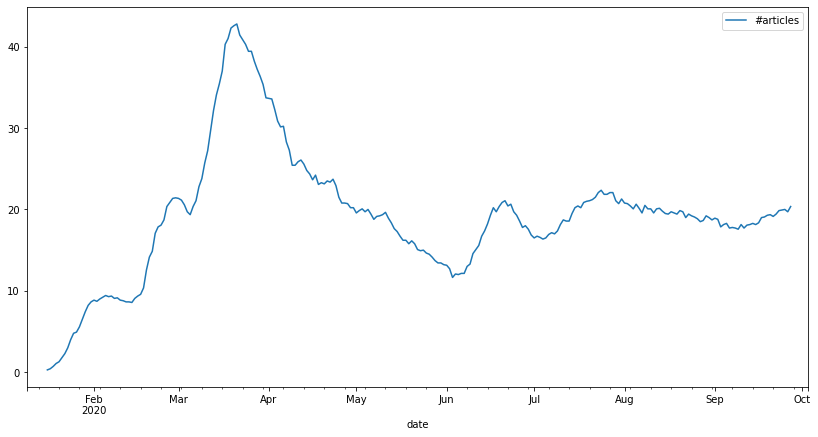

In [ ]:
df_q1 = df_all.set_index('date')[["#articles"]].rolling(14, center=True).mean()
df_q1.plot(figsize=(14, 7))

In [ ]:
df_q1.idxmax()

#articles   2020-03-21 00:00:00+00:00
dtype: datetime64[ns, UTC]

So, the most articles were published in a 14 day window around 2020-03-21. It is like twice as much as in September and four times as much as in February.

<a id='Q2'></a>
## 2. Why April was so intense in covid related news articles in 15min.lt?


We will try to answer this question by looking to the highest correlating feature in our covid dataset.

In [ ]:
df_corr = df_all.corr()[["#articles"]]
cm = sns.light_palette("green", as_cmap=True)
df_corr.style.background_gradient(cmap=cm)

,#articles
total_cases,0.049471
new_cases,0.165376
new_cases_smoothed,0.240014
total_deaths,0.004956
new_deaths,0.125535
new_deaths_smoothed,0.166795
total_cases_per_million,0.049471
new_cases_per_million,0.165378
new_cases_smoothed_per_million,0.240010
total_deaths_per_million,0.004955


So the other highest correlating feature is *positive_rate*. Let's look at relational plot.

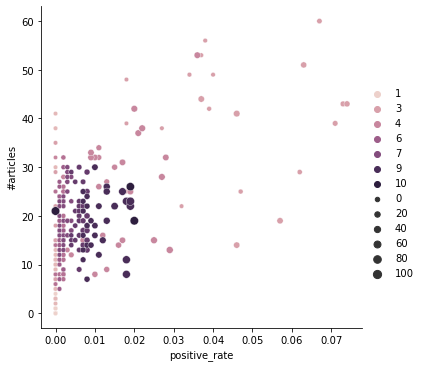

In [ ]:
df_all['month'] = df_all['date'].dt.month
# my matplotlb version has a bug so size and hue parameters has to receive lists...
ax = sns.relplot(data=df_all, x="positive_rate", y="#articles", 
                 size=df_all.new_cases_smoothed.tolist(), hue=df_all.month.tolist())
del df_all['month']

Here we can also see **month** by color and **new_cases_smoothed** by the size. So there is a slight correlation. Maybe the higher **positive_rate**, the more people want to know and they are reading more? Yet, as we see, the most of high positive rate was only during first months, as well as the biggest **#articles**. So it was new and people were eager to know more.

<a id='Q3'></a>
## 3. Can we predict number of COVID articles from covid data better than with only articles history?
Let's create new feature **week_before** which will be a number of articles published during a day week ago. This will be the last column of our `df_all` DataFrame. Also, for convienence, we will place target feature **#articles** to a separate DataFrame `targets`.

In [ ]:
df_all = df_all.set_index("date")
targets = df_all[["#articles"]]
del df_all["#articles"]
df_all['week_before'] = 0
df_all.iloc[7:, -1] = targets.iloc[:-7].values

df_all.head()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,week_before
date,,,,,,,,,,,,,,,,,,,,,
2020-01-09 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-01-10 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-01-11 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-01-12 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-01-13 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
targets.head(10)

,#articles
date,
2020-01-09 00:00:00+00:00,1
2020-01-10 00:00:00+00:00,0
2020-01-11 00:00:00+00:00,0
2020-01-12 00:00:00+00:00,0
2020-01-13 00:00:00+00:00,1
2020-01-14 00:00:00+00:00,0
2020-01-15 00:00:00+00:00,0
2020-01-16 00:00:00+00:00,0
2020-01-17 00:00:00+00:00,0


In [ ]:
def experiment(X_train_, y_train_, X_test_, y_test_):
    pipe0 = Pipeline([('scaler', StandardScaler()), ('svc', LinearRegression())])
    pipe0 = pipe0.fit(X_train_, y_train_)
    score = pipe0.score(X_test_, y_test_)
    y_test_['predicted'] = pipe0.predict(X_test_.values)
    y_test_.plot(figsize=(14,7), title=f"score: {score}")

Let's try only with **before_week** feature. Here we feed all except last 30 rows (samples) as train data, and only last 30 as test. 

2020-10-06 12:50:15 [py.warnings] WARNING: /home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



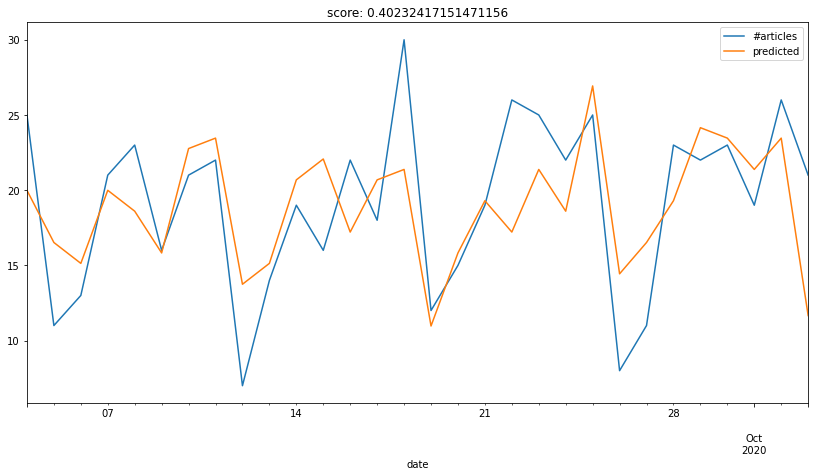

In [ ]:
experiment(df_all.iloc[:-30, [-1]], targets.iloc[:-30],
           df_all.iloc[-30:, [-1]], targets.iloc[-30:])

Now include also covid data

2020-10-06 12:50:16 [py.warnings] WARNING: /home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



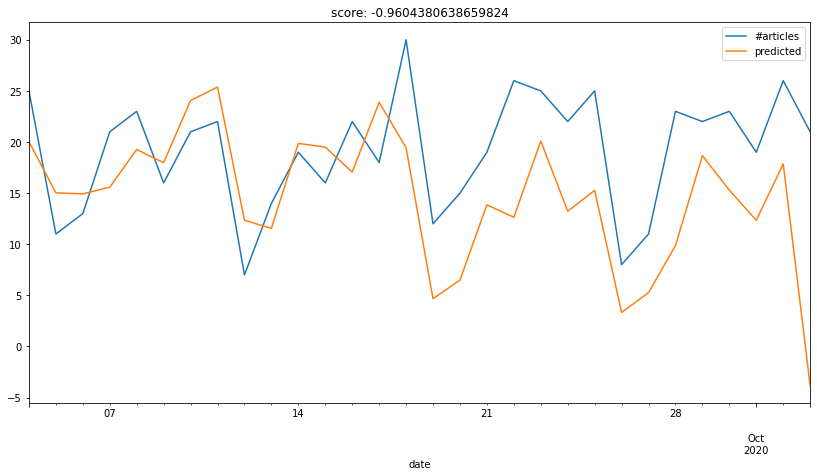

In [ ]:
experiment(df_all.iloc[:-30,:], targets.iloc[:-30],
           df_all.iloc[-30:, :], targets.iloc[-30:])

So, the better is to not use covid data at all. 0.4 vs-0.9. (The best score would be 1).
But that it would be, if use the best correlating feature **postive_rate**?

2020-10-06 12:50:16 [py.warnings] WARNING: /home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



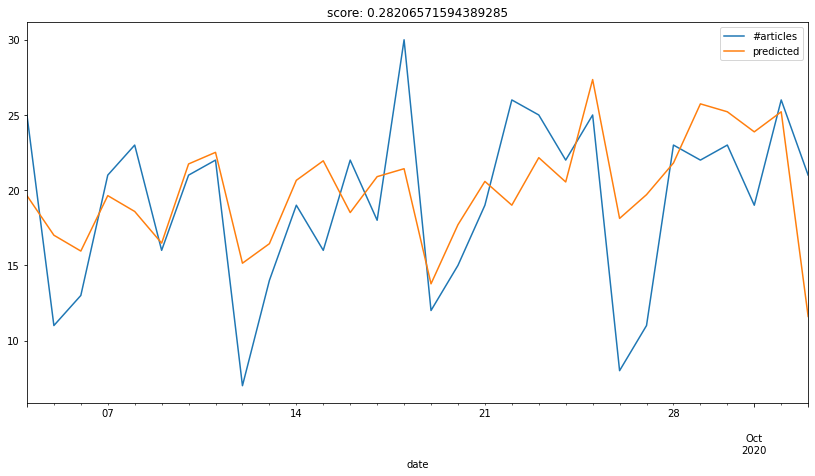

In [ ]:
experiment(df_all.iloc[:-30, -2:], targets.iloc[:-30],
           df_all.iloc[-30:, -2:], targets.iloc[-30:])

0.28 is still lower than 0.40.  
## Conclusion

data used | result (R$^{2}$)
--- | --- 
*week before feature* | 0.40
*week before + positive_cases* | 0.28
*week before + all covid featuers* | -0.96

**Do not use covid data to predict number of articles about covid.**